In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import sys, os 
sys.path.insert(0, os.path.dirname(os.getcwd()))

# @title Imports
import dataclasses
import datetime
import functools
import math
import re
from typing import Optional
from glob import glob

import cartopy.crs as ccrs
#from google.cloud import storage
from wofscast import autoregressive
from wofscast import casting
from wofscast import checkpoint
from wofscast import data_utils
from wofscast import my_graphcast as graphcast
from wofscast import normalization
from wofscast import rollout
from wofscast import xarray_jax
from wofscast import xarray_tree
from IPython.display import HTML
import ipywidgets as widgets
import haiku as hk
import jax
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import xarray #as xr

from wofscast.utils import count_total_parameters, save_model_params, load_model_params 

# For training the weights!
import optax
import jax
import numpy as np
import jax.numpy as jnp

from jax import device_put

from jax import pmap, device_put, local_device_count

# Check available devices
print("Available devices:", jax.devices())

from jax import tree_util


# In[2]:


# Notes on GraphCast Changes to run with WoFS data.

# 1. Introduced time dimension with timedeltas dataset
# 2. Introduce level dimension to the dataset 
# 3. Added try/excepts for xarray_jax to avoid PyTree errors about registry 
# 4. Cuda-enabled jaxlib error; had to install jax with this command for Cuda 11.8 
# pip install --upgrade "jax[cuda11_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# 5. Need to add the forcing variables (radiation) to the dataset
# 6. Xarray 2024.1.1 raised TracerArrayConversionError, downgraded to 2023.7.0, the version 
#    used in colab in the demo notebook.


""" usage: stdbuf -oL python -u train_graphcast_with_wofs.py > & log_trainer_models & """


# Initial params: mesh =5, latent

mesh_size = 5
latent_size = 128
gnn_msg_steps = 8
hidden_layers = 2

input_variables = ['U', 'V', 'W', 'T']#, 'P', 'REFL_10CM', 'UP_HELI_MAX']
target_variables = ['U', 'V', 'W', 'T']#, 'P', 'REFL_10CM', 'UP_HELI_MAX']
forcing_variables = ["XLAND"]#, 'HGT']

vars_2D = [] #['UP_HELI_MAX']

# Weights used in the loss equation.
VARIABLE_WEIGHTS = {v : 1.0 for v in target_variables}
VARIABLE_WEIGHTS['W'] = 2.0
#VARIABLE_WEIGHTS['UP_HELI_MAX'] = 2.0

# Not pressure levels, but just vertical array indices at the moment. 
pressure_levels = np.arange(0, 40) #list(np.arange(0,40,2))
radius_query_fraction_edge_length=5

# Loads data from the past 10 minutes and 
# creates a target lead time 5-30, in 5 min intervals
input_duration = '20min'
train_lead_times = '10min' 

model_config = graphcast.ModelConfig(
      resolution=0,
      mesh_size=mesh_size,
      latent_size=latent_size,
      gnn_msg_steps=gnn_msg_steps,
      hidden_layers=hidden_layers,
      radius_query_fraction_edge_length=radius_query_fraction_edge_length)

task_config = graphcast.TaskConfig(
      input_variables=input_variables,
      target_variables=target_variables,
      forcing_variables=forcing_variables,
      pressure_levels=pressure_levels,
      input_duration=input_duration,
  )


# Load the data 
#print('Loading the training data....')
base_path = '/work/mflora/wofs-cast-data/train_datasets'

# This data is only loaded for building the model. The true training dataset
# is loaded by the data generator below. 

train_inputs = xarray.load_dataset(os.path.join(base_path, 'train_inputs_batch_0.nc'))
train_targets = xarray.load_dataset(os.path.join(base_path, 'train_targets_batch_0.nc'))
train_forcings = xarray.load_dataset(os.path.join(base_path, 'train_forcings_batch_0.nc'))

train_inputs = train_inputs.transpose("batch", 'time', 'lat', 'lon', 'level')
train_targets = train_targets.transpose("batch", 'time', 'lat', 'lon', 'level')
train_forcings = train_forcings.transpose("batch", 'time', 'lat', 'lon')

#print("*"*80)
#print("Train Inputs:  ", train_inputs.dims.mapping)
#print("Train Targets: ", train_targets.dims.mapping)
#print("Train Forcings:", train_forcings.dims.mapping)
#print("*"*80)


# Load the normalization datasets
base_path = '/work/mflora/wofs-cast-data/normalization_stats'
mean_by_level = xarray.load_dataset(os.path.join(base_path, 'mean_by_level.nc'))
stddev_by_level = xarray.load_dataset(os.path.join(base_path, 'stddev_by_level.nc'))
diffs_stddev_by_level = xarray.load_dataset(os.path.join(base_path, 'diffs_stddev_by_level.nc'))


def construct_wrapped_graphcast(
    model_config: graphcast.ModelConfig,
    task_config: graphcast.TaskConfig):
    """Constructs and wraps the GraphCast Predictor."""

    # Deeper one-step predictor.
    predictor = graphcast.GraphCast(model_config, task_config, VARIABLE_WEIGHTS, vars_2D)

    # Modify inputs/outputs to `graphcast.GraphCast` to handle conversion to
    # from/to float32 to/from BFloat16.
    predictor = casting.Bfloat16Cast(predictor)

    # Modify inputs/outputs to `casting.Bfloat16Cast` so the casting to/from
    # BFloat16 happens after applying normalization to the inputs/targets.
    predictor = normalization.InputsAndResiduals(
      predictor,
      diffs_stddev_by_level=diffs_stddev_by_level,
      mean_by_level=mean_by_level,
      stddev_by_level=stddev_by_level)

    # Wraps everything so the one-step model can produce trajectories.
    predictor = autoregressive.Predictor(predictor, gradient_checkpointing=True)
    
    return predictor


@hk.transform_with_state
def run_forward(model_config, task_config, inputs, targets_template, forcings):
  predictor = construct_wrapped_graphcast(model_config, task_config)
  return predictor(inputs, targets_template=targets_template, forcings=forcings)


@hk.transform_with_state
def loss_fn(model_config, task_config, inputs, targets, forcings):
    predictor = construct_wrapped_graphcast(model_config, task_config)
    loss, diagnostics = predictor.loss(inputs, targets, forcings)
    return xarray_tree.map_structure(
      lambda x: xarray_jax.unwrap_data(x.mean(), require_jax=True),
      (loss, diagnostics))

def grads_fn(params, state, model_config, task_config, inputs, targets, forcings):
    def _aux(params, state, i, t, f):
        (loss, diagnostics), next_state = loss_fn.apply(
            params, state, jax.random.PRNGKey(0), model_config, task_config,
            i, t, f)
        return loss, (diagnostics, next_state)
      
        (loss, (diagnostics, next_state)), grads = jax.value_and_grad(
          _aux, has_aux=True)(params, state, inputs, targets, forcings)
    return loss, diagnostics, next_state, grads

# Jax doesn't seem to like passing configs as args through the jit. Passing it
# in via partial (instead of capture by closure) forces jax to invalidate the
# jit cache if you change configs.
def with_configs(fn):
  return functools.partial(
      fn, model_config=model_config, task_config=task_config)

# Always pass params and state, so the usage below are simpler
def with_params(fn):
  return functools.partial(fn, params=model_params, state=state)

# Our models aren't stateful, so the state is always empty, so just return the
# predictions. This is requiredy by our rollout code, and generally simpler.
def drop_state(fn):
  return lambda **kw: fn(**kw)[0]

init_jitted = jax.jit(with_configs(run_forward.init))

model_params, state = init_jitted(
    rng=jax.random.PRNGKey(0),
    inputs=train_inputs,
    targets_template=train_targets,
    forcings=train_forcings)


num = count_total_parameters(model_params)
print(f'Num of Parameters: {num}')

#base_path = '/work/mflora/wofs-cast-data/model'
#params_path = os.path.join(base_path, 'test_params.npz')
#save_model_params(model_params, params_path)

# Define the gradient function
def grads_fn(params, state, inputs, targets, forcings, model_config, task_config):
    def compute_loss(params, state, inputs, targets, forcings):
        (loss, diagnostics), next_state = loss_fn.apply(params, state, 
                                                        jax.random.PRNGKey(0), 
                                                        model_config, 
                                                        task_config, 
                                                        inputs, targets, forcings)
        return loss, (diagnostics, next_state)
    
    # Compute gradients and auxiliary outputs
    (loss, (diagnostics, next_state)), grads = jax.value_and_grad(compute_loss, has_aux=True)(params, state, 
                                                                                              inputs, targets, 
                                                                                              forcings)
    
    # Compute the global norm of all gradients
    total_norm = jnp.sqrt(sum(jnp.sum(jnp.square(g)) for g in tree_util.tree_leaves(grads)))

    # Clip gradients if the total norm exceeds the threshold
    def clip_grads(g, clip_norm=32):
        return jnp.where(total_norm > clip_norm, g * clip_norm / total_norm, g)

    clipped_grads = tree_util.tree_map(clip_grads, grads)

    
    return loss, diagnostics, next_state, grads

# remove `with_params` from jitted grads function
grads_fn_jitted = jax.jit(with_configs(grads_fn))


def get_random_batches(inputs, targets, forcings, batch_size):
    total_samples = inputs.dims['batch']
    indices = np.arange(total_samples)
    np.random.shuffle(indices)  # Randomly shuffle the indices

    for start_idx in range(0, total_samples, batch_size):
        end_idx = min(start_idx + batch_size, total_samples)
        batch_indices = indices[start_idx:end_idx]
        yield (inputs.isel(batch=batch_indices), 
               targets.isel(batch=batch_indices), 
               forcings.isel(batch=batch_indices))

        
def data_generator(n_round_per_epoch, n_timesteps=1):
    

     times = np.arange(n_timesteps)
    
    for i in range(n_round_per_epochs):
        train_inputs = xarray.load_dataset(os.path.join(base_path, f'train_inputs_batch_{i}.nc'))
        train_targets = xarray.load_dataset(os.path.join(base_path, f'train_targets_batch_{i}.nc'))
        train_forcings = xarray.load_dataset(os.path.join(base_path, f'train_forcings_batch_{i}.nc'))

        train_inputs = train_inputs.transpose("batch", 'time', 'lat', 'lon', 'level')
        train_targets = train_targets.transpose("batch", 'time', 'lat', 'lon', 'level')
        train_forcings = train_forcings.transpose("batch", 'time', 'lat', 'lon')
        
        # Select the number of forward timesteps
        train_targets = train_targets.isel(time = times)
        train_forcings = train_forcings.isel(time = times)

        yield train_inputs, train_targets, train_forcings
    
        
# Training Parameters. 
TOTAL_LINEAR_EPOCHS = 1000
TOTAL_COSINE_EPOCHS = 5000
TOTAL_FINAL_EPOCHS = 1000 

NT = len(train_targets['time'])
FINAL_EPOCH_INTERVAL = TOTAL_FINAL_EPOCHS // NT

BATCH_SIZE = 32
N_BATCHES = 10
checkpoint = True

# Setup the learning rate schedule
start_learning_rate = 1e-6  # Start from 0
end_learning_rate = 1e-3  # Increase to 1e-3
schedule = optax.linear_schedule(init_value=start_learning_rate, 
                                 end_value=end_learning_rate, 
                                 transition_steps=TOTAL_LINEAR_EPOCHS)


base_path = '/work/mflora/wofs-cast-data/model/checkpoints'
params_path = os.path.join(base_path, 'params.npz')

training_loss_phase1 = np.zeros((TOTAL_LINEAR_EPOCHS))
training_loss_phase2 = np.zeros((TOTAL_COSINE_EPOCHS))
training_loss_phase3 = np.zeros((TOTAL_FINAL_EPOCHS))

# For the initial training, model is tuned for only one timestep. 
#train_targets_onestep  = train_targets.isel(time = [0])
#train_forcings_onestep = train_forcings.isel(time = [0])

# Training loop with linearly increasing learning rate
print(f'Training with a linearly increasing learning rate from {start_learning_rate} to {end_learning_rate }\n')
for epoch in range(TOTAL_LINEAR_EPOCHS): 
    # Get the current learning rate from the schedule
    lr = schedule(epoch)
    # Setup optimizer with the current learning rate
    optimiser = optax.adam(lr, b1=0.9, b2=0.95, eps=1e-8)
    if epoch == 0:
        # Initialize the optimizer state only at the beginning
        opt_state = optimiser.init(model_params)
    
    # Create mini-batches for the current epoch and compute gradients. 
    losses_per_epoch = []
    for batch_inputs, batch_targets, batch_forcings in data_generator(N_BATCHES):
    
    #for batch_inputs, batch_targets, batch_forcings in get_random_batches(train_inputs, train_targets_onestep, 
    #                                                                      train_forcings_onestep, 
    #                                                                      BATCH_SIZE):
        
        loss, diagnostics, next_state, grads = grads_fn_jitted(model_params, state, batch_inputs, 
                                                           batch_targets, batch_forcings)
        losses_per_epoch.append(loss)
        
        # Update parameters
        updates, opt_state = optimiser.update(grads, opt_state)
        model_params = optax.apply_updates(model_params, updates)
    
    # Every 50 epoches, save the model_params
    if epoch % 50 == 0 and checkpoint:
        print('Saving model params....')
        save_model_params(model_params, params_path)
            
    
    print(f"Phase 1 Epoch: {epoch}.....Loss: {np.mean(losses_per_epoch):.5f}")
    training_loss_phase1[epoch] = np.mean(losses_per_epoch)
        
# Initialize the cosine decay schedule from Optax
print('\nTraining with a cosine decaying schedule...')
cosine_schedule = optax.cosine_decay_schedule(init_value=1e-3, 
                                                  decay_steps=TOTAL_COSINE_EPOCHS, 
                                                  alpha=0)  # alpha=0 makes it decay to 0        

# Training loop with decaying learning rate
for epoch in range(TOTAL_COSINE_EPOCHS): 
    # Get the current learning rate from the schedule
    lr = cosine_schedule(epoch)
    # Setup optimizer with the current learning rate
    optimiser = optax.adam(lr, b1=0.9, b2=0.95, eps=1e-8)

    # Create mini-batches for the current epoch and compute gradients. 
    losses_per_epoch = []
    for batch_inputs, batch_targets, batch_forcings in data_generator(N_BATCHES):
    #for batch_inputs, batch_targets, batch_forcings in get_random_batches(train_inputs, train_targets_onestep, 
    #                                                                      train_forcings_onestep,
    #                                                                      BATCH_SIZE):
        loss, diagnostics, next_state, grads = grads_fn_jitted(model_params, state, batch_inputs, 
                                                           batch_targets, batch_forcings)
        losses_per_epoch.append(loss)
        
        # Update parameters
        updates, opt_state = optimiser.update(grads, opt_state)
        model_params = optax.apply_updates(model_params, updates) 
        
    print(f"Phase 2 Epoch: {epoch}.....Loss: {np.mean(losses_per_epoch):.5f}")
    training_loss_phase2[epoch] = np.mean(losses_per_epoch)
    
    # Every 50 epoches, save the model_params
    if epoch % 1000 == 0 and checkpoint:
        print('Saving model params....')
        save_model_params(model_params, params_path)
        
        
#TODO: Final training schedule for longer predictions. Increasing timesteps every 1000
# epoches with a fixed learning rate of 3e-7 (really low, but for fine tuning.)
# Training loop with decaying learning rate

print('\n Fine tuning the model by training on longer predictions...')

# Setup optimizer with the current learning rate
optimiser = optax.adam(3e-7, b1=0.9, b2=0.95, eps=1e-8)

#time_rng = [0,1]
#train_targets_multi_step  = train_targets.isel(time = time_rng)
#train_forcings_multi_step = train_forcings.isel(time = time_rng)

n_timesteps = 1 
for epoch in range(TOTAL_FINAL_EPOCHS):
    
    # Steadily increase the lead time evaluated. 
    if epoch % FINAL_EPOCH_INTERVAL == 0: 
        n_timesteps+=1
        
        #new_val = max(time_rng)+1
        #if new_val != NT:
        #    time_rng.append(new_val)
        #    print(f'Training a new lead time: {time_rng}')
        #    train_targets_multi_step  = train_targets.isel(time = time_rng)
        #    train_forcings_multi_step = train_forcings.isel(time = time_rng)
    
    # Create mini-batches for the current epoch and compute gradients. 
    losses_per_epoch = []
    for batch_inputs, batch_targets, batch_forcings in data_generator(N_BATCHES, n_timesteps):
    
    #or batch_inputs, batch_targets, batch_forcings in get_random_batches(train_inputs, 
    #                                                                     train_targets_multi_step, 
    #                                                                      train_forcings_multi_step, 
    #                                                                      BATCH_SIZE):
        
        loss, diagnostics, next_state, grads = grads_fn_jitted(model_params, state, batch_inputs, 
                                                           batch_targets, batch_forcings)
        losses_per_epoch.append(loss)
        
        # Update parameters
        updates, opt_state = optimiser.update(grads, opt_state)
        model_params = optax.apply_updates(model_params, updates) 
        
    print(f"Phase 3 Epoch: {epoch}.....Loss: {np.mean(losses_per_epoch):.5f}")
    training_loss_phase3[epoch] = np.mean(losses_per_epoch)
    
    # Every 50 epoches, save the model_params
    if epoch % 1000 == 0 and checkpoint:
        print('Saving model params....')
        save_model_params(model_params, params_path)

# Final model
base_path = '/work/mflora/wofs-cast-data/model/'
params_path = os.path.join(base_path, 'params.npz')
save_model_params(model_params, params_path)

fig, axes = plt.subplots(dpi=300, ncols=3, figsize=(12,4))
titles = ['Phase 1', 'Phase 2', 'Phase 3']
for i, (ax, loss) in enumerate(zip(axes.flat, [training_loss_phase1, 
                                               training_loss_phase2, training_loss_phase3])):
    ax.set(ylabel='Loss', xlabel='Epoch', title=titles[i])
    ax.plot(loss)
    ax.grid(alpha=0.5)

plt.tight_layout()
plt.savefig('training_results.png')



### Run the model forward based on the new model params

In [37]:
# Always pass params and state, so the usage below are simpler
def with_model_params(fn):
  return functools.partial(fn, params=model_params, state=state)

run_forward_jitted = drop_state(with_model_params(jax.jit(with_configs(
    run_forward.apply))))

# @title Autoregressive rollout (keep the loop in JAX)
print("Inputs:  ", eval_inputs.dims.mapping)
print("Targets: ", eval_targets.dims.mapping)
print("Forcings:", eval_forcings.dims.mapping)

predictions = rollout.chunked_prediction(
    run_forward_jitted,
    rng=jax.random.PRNGKey(0),
    inputs=eval_inputs,
    targets_template=eval_targets * np.nan,
    forcings=eval_forcings)

predictions

Inputs:   {'batch': 1, 'time': 2, 'lat': 150, 'lon': 150, 'level': 40}
Targets:  {'batch': 1, 'time': 6, 'lat': 150, 'lon': 150, 'level': 40}
Forcings: {'batch': 1, 'time': 6, 'lat': 150, 'lon': 150}
n_mesh_node=array([545]), node_features.shape=(545, 3)


<xarray.Dataset>
Dimensions:  (time: 6, batch: 1, lat: 150, lon: 150, level: 40)
Coordinates:
  * time     (time) timedelta64[ns] 00:10:00 00:20:00 ... 00:50:00 01:00:00
  * lat      (lat) float32 30.06 30.09 30.12 30.14 ... 34.03 34.05 34.08 34.11
  * lon      (lon) float32 89.24 89.27 89.3 89.33 ... 93.67 93.7 93.73 93.76
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38 39
Dimensions without coordinates: batch
Data variables:
    T        (time, batch, lat, lon, level) float32 299.9 299.9 ... 408.1 424.1
    U        (time, batch, lat, lon, level) float32 2.986 5.266 ... 28.91 20.76
    V        (time, batch, lat, lon, level) float32 6.017 10.25 ... -2.222
    W        (time, batch, lat, lon, level) float32 -0.0004128 ... -0.1941

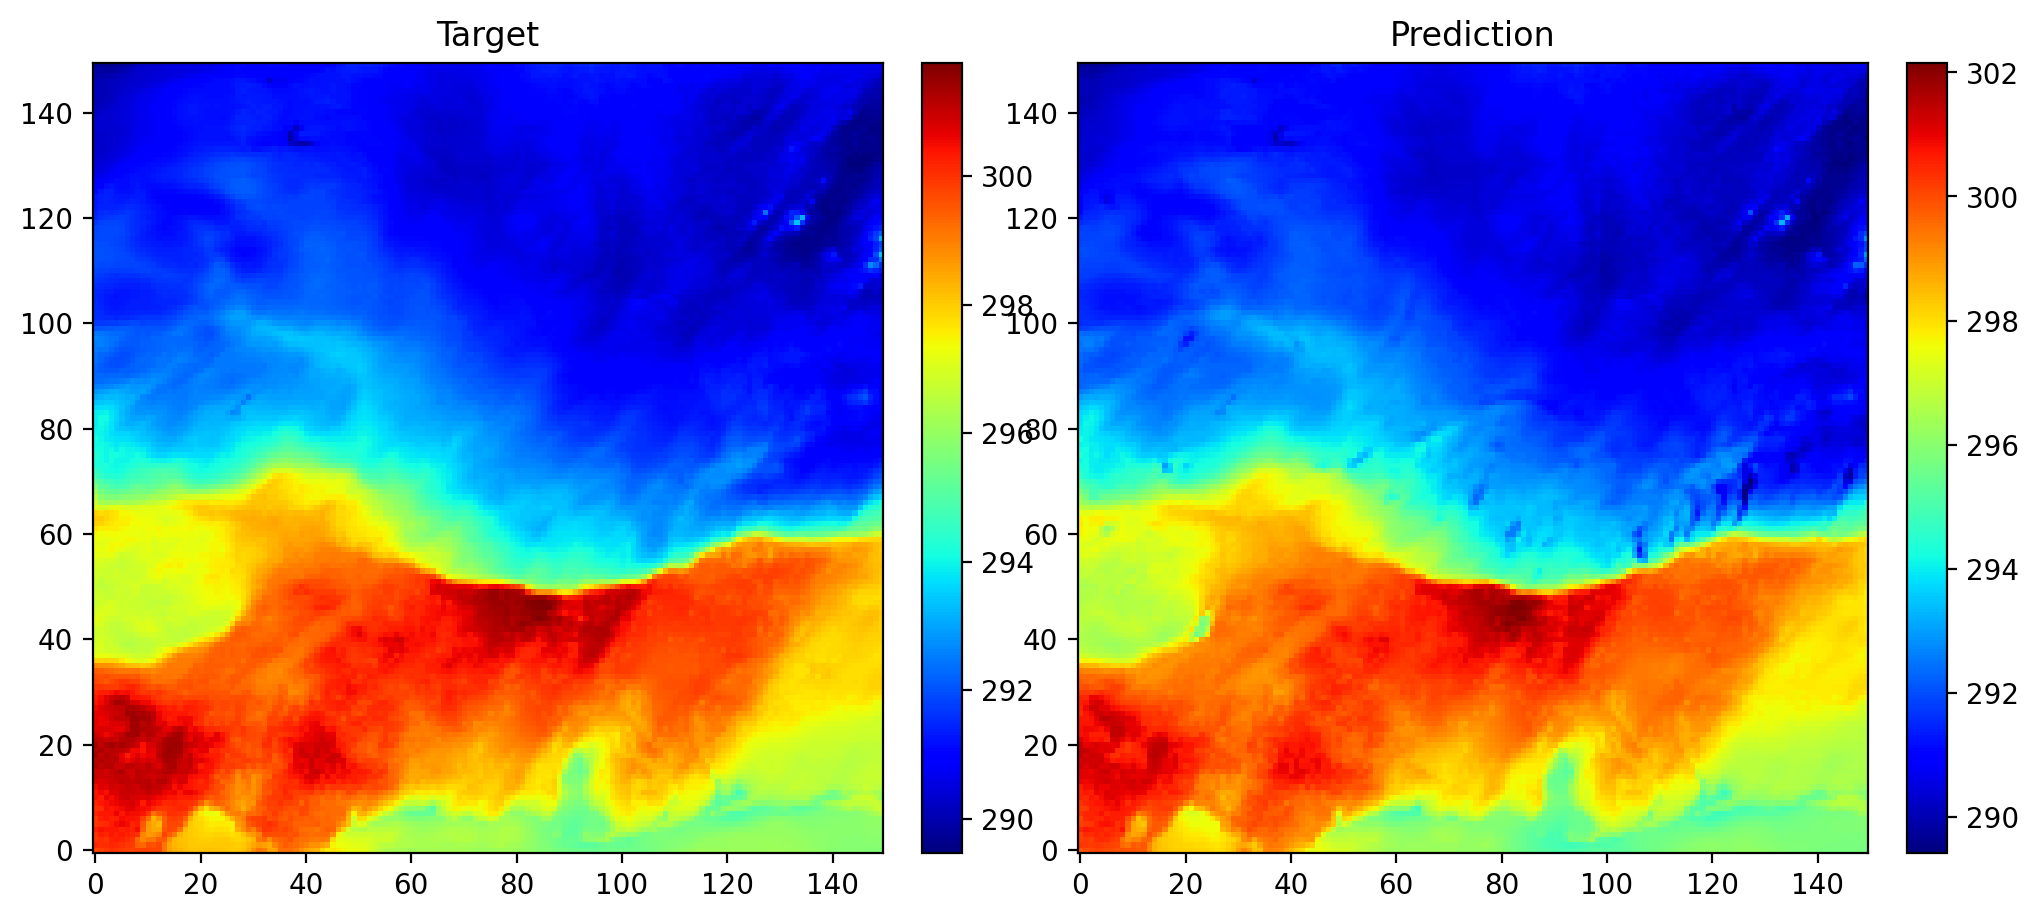

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

preds =  predictions.squeeze(dim='batch', drop=True)
targets = eval_targets.squeeze(dim='batch', drop=True)

#print(np.max(preds['T'][1] - preds['T'][1]))
#print(np.max(targets['T'][0] - targets['T'][0]))

var = 'T'
level = 'max'

def get_target_and_pred_pair(preds, targets, t, level=0):
    # (time, level, lat, lon )
    if level == 'max':
        zs = [targets[var][t].max(dim='level').values, preds[var][t].max(dim='level').values]
    elif level == 'min': 
        zs = [targets[var][t].min(dim='level').values, preds[var][t].min(dim='level').values]
    elif level == 'none':
        zs = [targets[var][t].values, preds[var][t].values]
    else:
        zs = [targets[var].isel(time=t, level=level).values, preds[var].isel(time=t, level=level).values]
    return zs 

fig, axes = plt.subplots(dpi=200, figsize=(10,6), ncols=2)
plt.tight_layout()

zs = get_target_and_pred_pair(preds, targets, t=0)

titles = ['Target', 'Prediction']
for i, (ax, z) in enumerate(zip(axes, zs)):
    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')
    if var in ['REFL_10CM', 'UP_HELI_MAX']:
        z = np.ma.masked_where(z<5,z)
    
    im = ax.imshow(z, origin='lower', aspect='equal', cmap='jet')
    cb = fig.colorbar(im, cax=cax)
    ax.set_title(titles[i])
    
# This function will update the content of the plot for each frame
def update(t):
    # Clear the current axes
    for ax in axes:
        ax.clear()

    zs = get_target_and_pred_pair(preds, targets, t=t)
    
    titles = ['Target', 'Prediction']
    for i, (ax, z) in enumerate(zip(axes, zs)):
        if var in ['REFL_10CM', 'UP_HELI_MAX']:
            z = np.ma.masked_where(z<5,z)
        im = ax.imshow(z, origin='lower', aspect='equal', cmap='jet')
        ax.set_title(titles[i])


# Total number of frames (adjust 'N' according to the size of your data along the 't' dimension)
N = targets[var].shape[0]  # Assuming the second dimension is 't'

# Create animation
anim = FuncAnimation(fig, update, frames=N, interval=200)  # Adjust interval for frame speed

# To display the animation in a Jupyter notebook
from IPython.display import HTML
HTML(anim.to_jshtml())